## 1. Import Required Libraries

In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from hira.index import KMeansIndex, KMeansIndexConfig, Index
from hira.search import HalfspaceSearcher

# Force single-threaded execution for consistent benchmarking
torch.set_num_threads(1)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Libraries imported successfully!


/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration and Setup

In [2]:
# Experiment configuration
CONFIG = {
    "num_keys_list": [10000, 20000, 40000, 50000, 60000, 100000],
    "branching_factors": [2, 4, 6, 8, 10, 15, 20, 32, 64],
    "distributions": ["real"],#, "uniform", "mixture_of_gaussians", "zipf"],
    "dim": 128,
    "device": "cuda",
    "target_results": 10,
    "max_iterations": 1,
    "seed": 42,
    "num_runs": 5,  # Number of times to run each experiment
    # "real_data_path": "/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "real_data_path": "/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_qwen_Qwen2.5-3B-Instruct_layer35_20251227_223030.npz",
    "output_csv": "benchmark_results.csv",
}

# Results storage
results = []

## 3. Data Generation Functions

In [3]:
def generate_uniform_data(num_keys: int, dim: int, seed: int = 42) -> torch.Tensor:
    """Generate uniformly distributed random vectors (Gaussian distribution)."""
    torch.manual_seed(seed)
    return torch.randn(num_keys, dim)


def generate_mixture_of_gaussians_data(
    num_keys: int, dim: int, num_gaussians: int = 10, seed: int = 42
) -> torch.Tensor:
    """Generate mixture of Gaussians using fitted parameters from real data."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Component parameters from GMM fitted to real KV cache data
    gmm_weights = np.array(
        [0.1255, 0.2067, 0.0046, 0.1678, 0.0027, 0.0928, 0.0143, 0.3021, 0.0258, 0.0576]
    )
    gmm_weights = gmm_weights / gmm_weights.sum()
    gmm_means = [1.3819, -0.9039, -12.4851, 0.6147, 10.9554, -1.9572, 4.2475, -0.0570, -3.3843, 2.4689]
    gmm_stds = [0.3879, 0.3699, 2.1610, 0.3008, 1.9482, 0.5171, 1.0753, 0.2514, 1.0471, 0.5737]

    # Sample component assignments based on weights
    component_assignments = np.random.choice(num_gaussians, size=num_keys, p=gmm_weights)

    # Generate points from each component
    keys = torch.zeros(num_keys, dim)
    for i in range(num_gaussians):
        component_mask = component_assignments == i
        n_points_in_component = component_mask.sum()
        if n_points_in_component > 0:
            component_points = torch.randn(n_points_in_component, dim) * gmm_stds[i] + gmm_means[i]
            keys[component_mask] = component_points

    return keys


def generate_zipf_data(
    num_keys: int, dim: int, num_clusters: int = 10, s: float = 1.5, seed: int = 42
) -> torch.Tensor:
    """Generate data where cluster sizes follow a Zipf distribution."""
    torch.manual_seed(seed)

    # Generate Zipf probabilities for cluster sizes
    ranks = torch.arange(1, num_clusters + 1, dtype=torch.float32)
    probabilities = 1.0 / (ranks**s)
    probabilities = probabilities / probabilities.sum()

    # Assign number of points to each cluster
    cluster_sizes = (probabilities * num_keys).long()
    diff = num_keys - cluster_sizes.sum().item()
    cluster_sizes[0] += diff

    # Generate random cluster centers
    cluster_centers = torch.randn(num_clusters, dim) * 2
    scales = torch.rand(num_clusters, dim) * 0.5 + 0.3

    # Generate points from each cluster
    keys = torch.zeros(num_keys, dim)
    current_idx = 0
    for i in range(num_clusters):
        size = cluster_sizes[i].item()
        if size > 0:
            end_idx = current_idx + size
            keys[current_idx:end_idx] = cluster_centers[i] + torch.randn(size, dim) * scales[i]
            current_idx = end_idx

    return keys


def generate_real_data(
    num_keys: int, dim: int, real_data_path: str, seed: int = 42
) -> torch.Tensor:
    """Load real KV cache data from NPZ file."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    data = np.load(real_data_path)
    keys = torch.from_numpy(data["keys"]).float()

    # Subsample if needed
    if len(keys) > num_keys:
        indices = torch.randperm(len(keys))[:num_keys]
        keys = keys[indices]

    return keys


def generate_data(
    num_keys: int,
    dim: int,
    distribution: str = "uniform",
    seed: int = 42,
    real_data_path: str = None,
) -> torch.Tensor:
    """Generate test data based on distribution type."""
    if distribution == "uniform":
        return generate_uniform_data(num_keys, dim, seed)
    elif distribution == "mixture_of_gaussians":
        return generate_mixture_of_gaussians_data(num_keys, dim, seed=seed)
    elif distribution == "zipf":
        return generate_zipf_data(num_keys, dim, seed=seed)
    elif distribution == "real":
        if real_data_path is None:
            raise ValueError("real_data_path must be provided for 'real' distribution")
        return generate_real_data(num_keys, dim, real_data_path, seed=seed)
    else:
        raise ValueError(f"Unknown distribution: {distribution}")

print("Data generation functions defined!")

Data generation functions defined!


## 4. Search Function Implementations

In [6]:
def brute_force_search(index: Index, query: torch.Tensor, threshold: float) -> torch.Tensor:
    """Brute-force search."""
    query_norm = query / torch.norm(query, p=2)
    scores = torch.matmul(index.keys, query_norm)
    result = (scores >= threshold).nonzero(as_tuple=True)[0]
    return result


def indexed_search(index: Index, query: torch.Tensor, threshold: float) -> torch.Tensor:
    """Indexed search using HalfspaceSearcher."""
    searcher = HalfspaceSearcher(enable_profiling=False)
    result = searcher.search(query, threshold, index)
    return result


def run_single_benchmark(
    keys: torch.Tensor,
    branching_factor: int,
    dim: int,
    device: str,
    max_iterations: int,
    target_results: int,
    num_runs: int = 5
) -> Tuple[float, float, float, float, int, int]:
    """Run a single benchmark multiple times and return average timings with std dev."""
    keys = keys.to(device)
    
    # Calculate number of levels
    num_levels = math.ceil(math.log(len(keys)) / math.log(branching_factor))
    
    # Build index (only once)
    config = KMeansIndexConfig(
        num_levels=num_levels,
        branching_factor=branching_factor,
        max_iterations=max_iterations,
        device=device,
    )
    index = KMeansIndex(config)
    index.build(keys)
    
    # Create query and find threshold (only once)
    query = torch.randn(dim).to(device)
    query_norm = query / torch.norm(query, p=2)
    all_scores = torch.matmul(keys, query_norm)
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    threshold = sorted_scores[min(target_results, len(sorted_scores) - 1)].item()
    
    # Run multiple times
    bf_times = []
    indexed_times = []
    bf_count = 0
    indexed_count = 0
    
    for _ in range(num_runs):
        # Time brute-force search
        start_time = time.time()
        result_bf = brute_force_search(index, query, threshold)
        bf_times.append(time.time() - start_time)
        bf_count = len(result_bf)
        
        # Time indexed search
        start_time = time.time()
        result_indexed = indexed_search(index, query, threshold)
        indexed_times.append(time.time() - start_time)
        indexed_count = len(result_indexed)
    
    # Calculate averages and standard deviations
    bf_time_mean = np.mean(bf_times)
    bf_time_std = np.std(bf_times)
    indexed_time_mean = np.mean(indexed_times)
    indexed_time_std = np.std(indexed_times)
    
    return bf_time_mean, bf_time_std, indexed_time_mean, indexed_time_std, bf_count, indexed_count

print("Search functions defined!")

Search functions defined!


## 5. Run Benchmark Experiments

Run benchmarks across all distributions and configurations.

### Load Existing Results (Optional)

If you want to skip running experiments and load previously saved results, run this cell:

In [ ]:
# Uncomment to load existing results instead of running experiments
# output_csv = Path(CONFIG['output_csv'])
# if output_csv.exists():
#     df_results = pd.read_csv(output_csv)
#     print(f"✓ Loaded {len(df_results)} results from {output_csv.absolute()}")
#     print(f"  Columns: {list(df_results.columns)}")
#     print(f"  Distributions: {df_results['distribution'].unique()}")
#     print(f"  Key counts: {sorted(df_results['num_keys'].unique())}")
#     print(f"  Branching factors: {sorted(df_results['branching_factor'].unique())}")
# else:
#     print(f"No existing results found at {output_csv.absolute()}")

In [7]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Calculate total experiments
total_experiments = len(CONFIG['distributions']) * len(CONFIG['num_keys_list']) * len(CONFIG['branching_factors'])

print(f"Running {total_experiments} experiments (each {CONFIG['num_runs']} times)...")
print(f"Total iterations: {total_experiments * CONFIG['num_runs']}")
print(f"Results will be saved to: {output_csv.absolute()}")
print("=" * 80)

# Create overall progress bar
overall_pbar = tqdm(total=total_experiments, desc="Overall Progress", position=0, leave=True)

for distribution in CONFIG['distributions']:
    print(f"\n{'='*80}")
    print(f"Distribution: {distribution.upper()}")
    print(f"{'='*80}")
    
    for num_keys in CONFIG['num_keys_list']:
        print(f"\n  Keys: {num_keys:,}")
        
        # Generate data once for this num_keys
        keys = generate_data(
            num_keys,
            CONFIG['dim'],
            distribution=distribution,
            seed=CONFIG['seed'],
            real_data_path=CONFIG['real_data_path']
        )
        
        # Create progress bar for branching factors
        bf_pbar = tqdm(
            CONFIG['branching_factors'], 
            desc=f"    BF Progress", 
            position=1,
            leave=False
        )
        
        for branching_factor in bf_pbar:
            bf_pbar.set_description(f"    BF={branching_factor:2d}")
            
            try:
                bf_time_mean, bf_time_std, indexed_time_mean, indexed_time_std, bf_count, indexed_count = run_single_benchmark(
                    keys,
                    branching_factor,
                    CONFIG['dim'],
                    CONFIG['device'],
                    CONFIG['max_iterations'],
                    CONFIG['target_results'],
                    CONFIG['num_runs']
                )
                
                speedup = bf_time_mean / indexed_time_mean if indexed_time_mean > 0 else 0
                
                result = {
                    'distribution': distribution,
                    'num_keys': num_keys,
                    'branching_factor': branching_factor,
                    'brute_force_time_mean': bf_time_mean,
                    'brute_force_time_std': bf_time_std,
                    'indexed_time_mean': indexed_time_mean,
                    'indexed_time_std': indexed_time_std,
                    'speedup': speedup,
                    'bf_count': bf_count,
                    'indexed_count': indexed_count,
                    'num_runs': CONFIG['num_runs']
                }
                
                results.append(result)
                
                # Update progress bar with stats
                bf_pbar.set_postfix({
                    'BF_ms': f"{bf_time_mean*1000:.2f}±{bf_time_std*1000:.2f}",
                    'Idx_ms': f"{indexed_time_mean*1000:.2f}±{indexed_time_std*1000:.2f}",
                    'Speedup': f"{speedup:.2f}x"
                })
                
            except Exception as e:
                print(f"\n    ERROR at BF={branching_factor}: {str(e)}")
                results.append({
                    'distribution': distribution,
                    'num_keys': num_keys,
                    'branching_factor': branching_factor,
                    'brute_force_time_mean': None,
                    'brute_force_time_std': None,
                    'indexed_time_mean': None,
                    'indexed_time_std': None,
                    'speedup': None,
                    'bf_count': None,
                    'indexed_count': None,
                    'num_runs': CONFIG['num_runs']
                })
            
            # Update overall progress
            overall_pbar.update(1)
            
            # Save intermediate results to CSV after each experiment
            pd.DataFrame(results).to_csv(output_csv, index=False)

overall_pbar.close()

# Convert to DataFrame
df_results = pd.DataFrame(results)

print(f"\n{'='*80}")
print("All experiments completed!")
print(f"{'='*80}")
print(f"\nTotal results: {len(df_results)}")
print(f"Successful: {df_results['speedup'].notna().sum()}")
print(f"Failed: {df_results['speedup'].isna().sum()}")
print(f"\nResults saved to: {output_csv.absolute()}")

Running 54 experiments (each 5 times)...
Total iterations: 270
Results will be saved to: /home/mohsen/kvcache/hira/tests/indexes_benchmark/benchmark_results.csv


Overall Progress:   0%|          | 0/54 [00:00<?, ?it/s]


Distribution: REAL

  Keys: 10,000


WARNING clustering 10000 points to 5000 centroids: please provide at least 195000 training points
WARNING clustering 5000 points to 2500 centroids: please provide at least 97500 training points
WARNING clustering 2500 points to 1250 centroids: please provide at least 48750 training points
WARNING clustering 1250 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 19 centroids: please provide at least 741 training points
WARNING clustering 19 points to 9 centroids: please provide at least 351 training points
WARNING clustering 9 points to 4 centroids: please provide at leas


  Keys: 20,000


WARNING clustering 20000 points to 10000 centroids: please provide at least 390000 training points
WARNING clustering 10000 points to 5000 centroids: please provide at least 195000 training points
WARNING clustering 5000 points to 2500 centroids: please provide at least 97500 training points
WARNING clustering 2500 points to 1250 centroids: please provide at least 48750 training points
WARNING clustering 1250 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 19 centroids: please provide at least 741 training points
WARNING clustering 19 points to 9 centroids: please prov


  Keys: 40,000


WARNING clustering 40000 points to 20000 centroids: please provide at least 780000 training points
WARNING clustering 20000 points to 10000 centroids: please provide at least 390000 training points
WARNING clustering 10000 points to 5000 centroids: please provide at least 195000 training points
WARNING clustering 5000 points to 2500 centroids: please provide at least 97500 training points
WARNING clustering 2500 points to 1250 centroids: please provide at least 48750 training points
WARNING clustering 1250 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 19 centroids: p


  Keys: 50,000


WARNING clustering 50000 points to 25000 centroids: please provide at least 975000 training points
WARNING clustering 25000 points to 12500 centroids: please provide at least 487500 training points
WARNING clustering 12500 points to 6250 centroids: please provide at least 243750 training points
WARNING clustering 6250 points to 3125 centroids: please provide at least 121875 training points
WARNING clustering 3125 points to 1562 centroids: please provide at least 60918 training points
WARNING clustering 1562 points to 781 centroids: please provide at least 30459 training points
WARNING clustering 781 points to 390 centroids: please provide at least 15210 training points
WARNING clustering 390 points to 195 centroids: please provide at least 7605 training points
WARNING clustering 195 points to 97 centroids: please provide at least 3783 training points
WARNING clustering 97 points to 48 centroids: please provide at least 1872 training points
WARNING clustering 48 points to 24 centroids: 


  Keys: 60,000


WARNING clustering 60000 points to 30000 centroids: please provide at least 1170000 training points
WARNING clustering 30000 points to 15000 centroids: please provide at least 585000 training points
WARNING clustering 15000 points to 7500 centroids: please provide at least 292500 training points
WARNING clustering 7500 points to 3750 centroids: please provide at least 146250 training points
WARNING clustering 3750 points to 1875 centroids: please provide at least 73125 training points
WARNING clustering 1875 points to 937 centroids: please provide at least 36543 training points
WARNING clustering 937 points to 468 centroids: please provide at least 18252 training points
WARNING clustering 468 points to 234 centroids: please provide at least 9126 training points
WARNING clustering 234 points to 117 centroids: please provide at least 4563 training points
WARNING clustering 117 points to 58 centroids: please provide at least 2262 training points
WARNING clustering 58 points to 29 centroid


  Keys: 100,000


WARNING clustering 89740 points to 44870 centroids: please provide at least 1749930 training points
WARNING clustering 44870 points to 22435 centroids: please provide at least 874965 training points
WARNING clustering 22435 points to 11217 centroids: please provide at least 437463 training points
WARNING clustering 11217 points to 5608 centroids: please provide at least 218712 training points
WARNING clustering 5608 points to 2804 centroids: please provide at least 109356 training points
WARNING clustering 2804 points to 1402 centroids: please provide at least 54678 training points
WARNING clustering 1402 points to 701 centroids: please provide at least 27339 training points
WARNING clustering 701 points to 350 centroids: please provide at least 13650 training points
WARNING clustering 350 points to 175 centroids: please provide at least 6825 training points
WARNING clustering 175 points to 87 centroids: please provide at least 3393 training points
WARNING clustering 87 points to 43 ce


All experiments completed!

Total results: 54
Successful: 54
Failed: 0

Results saved to: /home/mohsen/kvcache/hira/tests/indexes_benchmark/benchmark_results.csv
CPU times: user 2min 39s, sys: 632 ms, total: 2min 40s
Wall time: 2min 40s


## 6. Results Overview

In [ ]:
# Display first few rows
# print("Sample Results:")
# print(df_results.head(20).to_string())

# Summary statistics by distribution
# print("\n" + "="*80)
# print("Summary Statistics by Distribution:")
# print("="*80)
# summary = df_results.groupby('distribution').agg({
#     'brute_force_time_mean': ['mean', 'std', 'min', 'max'],
#     'indexed_time_mean': ['mean', 'std', 'min', 'max'],
#     'speedup': ['mean', 'std', 'min', 'max']
# }).round(4)
# print(summary)

## 8. Visualization: Speedup Analysis

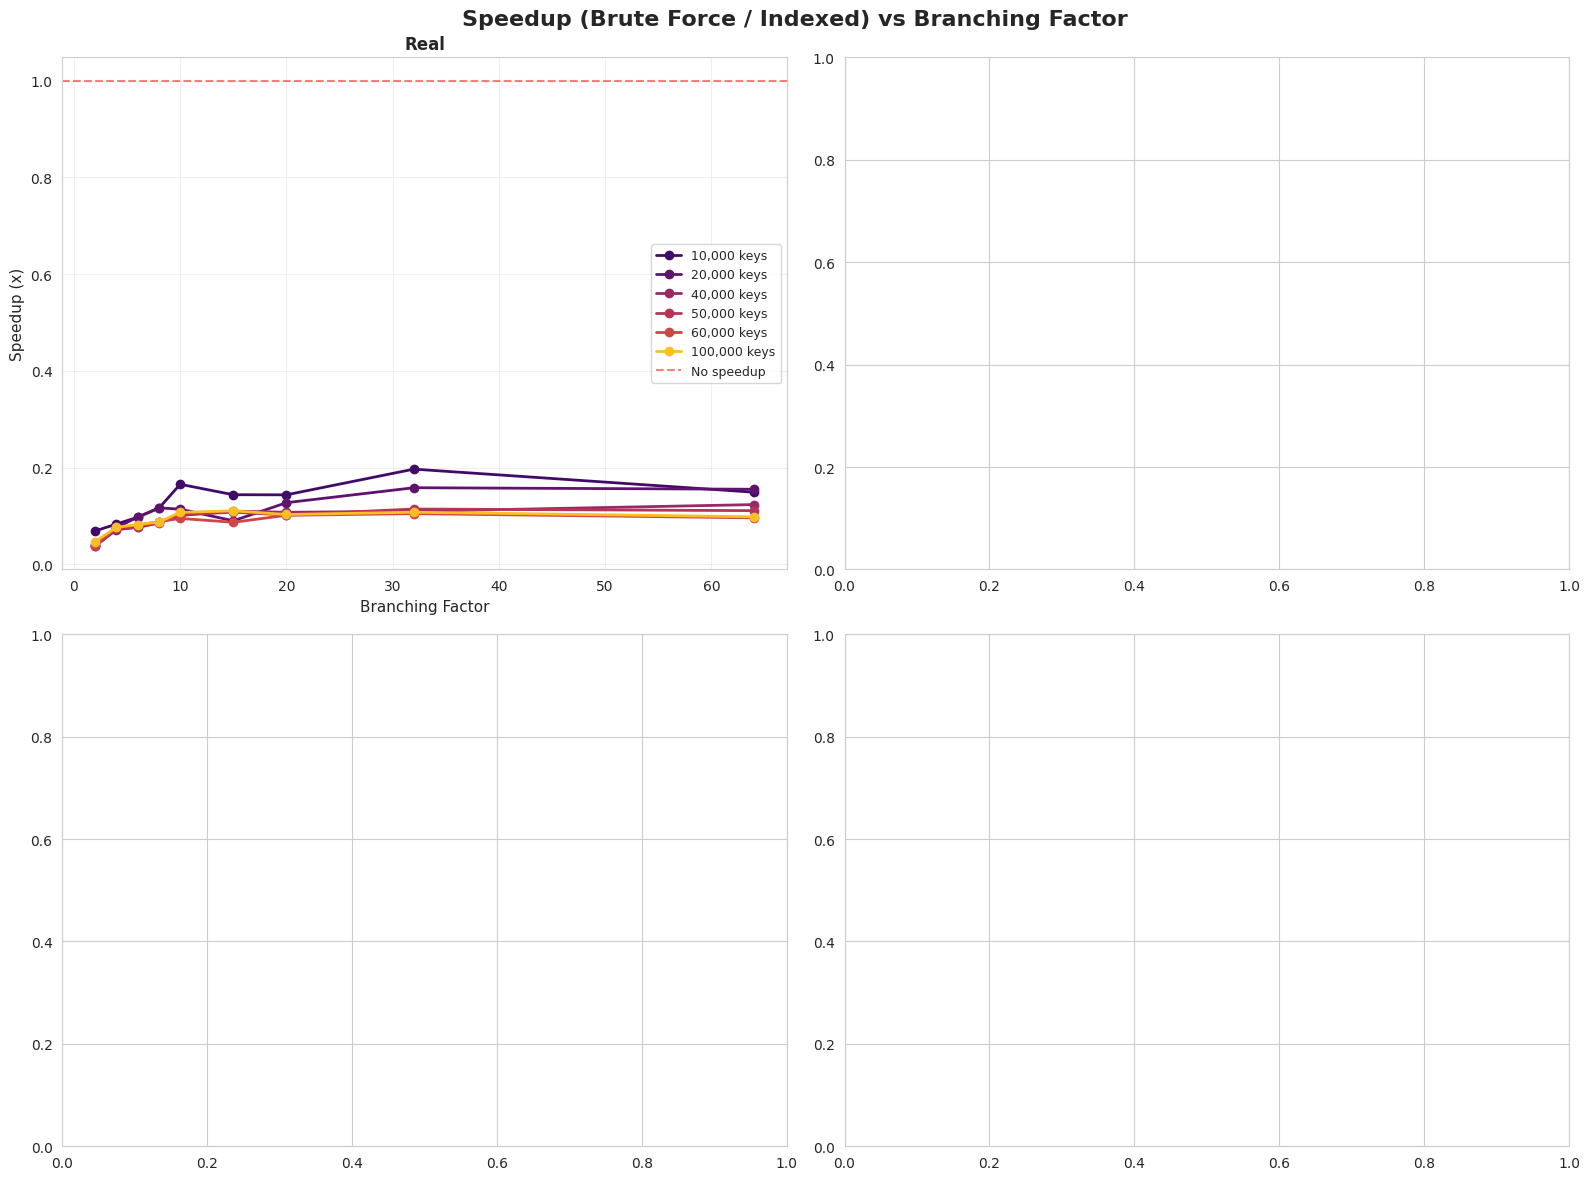

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Speedup (Brute Force / Indexed) vs Branching Factor', fontsize=16, fontweight='bold')
from matplotlib.colors import LinearSegmentedColormap
# Define key counts and create a gray-to-black color map
key_counts = [10000, 20000, 40000, 50000, 60000, 100000]

base = plt.cm.inferno
cmap = LinearSegmentedColormap.from_list(
    "inferno_dark",
    base(np.linspace(0.2, 0.85, 256))
)

norm = plt.Normalize(vmin=min(key_counts), vmax=max(key_counts))

for idx, distribution in enumerate(CONFIG['distributions']):
    ax = axes[idx // 2, idx % 2]
    
    df_dist = df_results[df_results['distribution'] == distribution]
    
    # Plot speedup for different number of keys with gray-to-black color scale
    for num_keys in key_counts:
        if num_keys in df_dist['num_keys'].values:
            df_nk = df_dist[df_dist['num_keys'] == num_keys]
            color = cmap(norm(num_keys))
            ax.plot(df_nk['branching_factor'], df_nk['speedup'], 
                   marker='o', linestyle='-', color=color, linewidth=2,
                   label=f'{num_keys:,} keys')
    
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
    ax.set_xlabel('Branching Factor', fontsize=11)
    ax.set_ylabel('Speedup (x)', fontsize=11)
    ax.set_title(f'{distribution.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Visualization: Average Execution Times

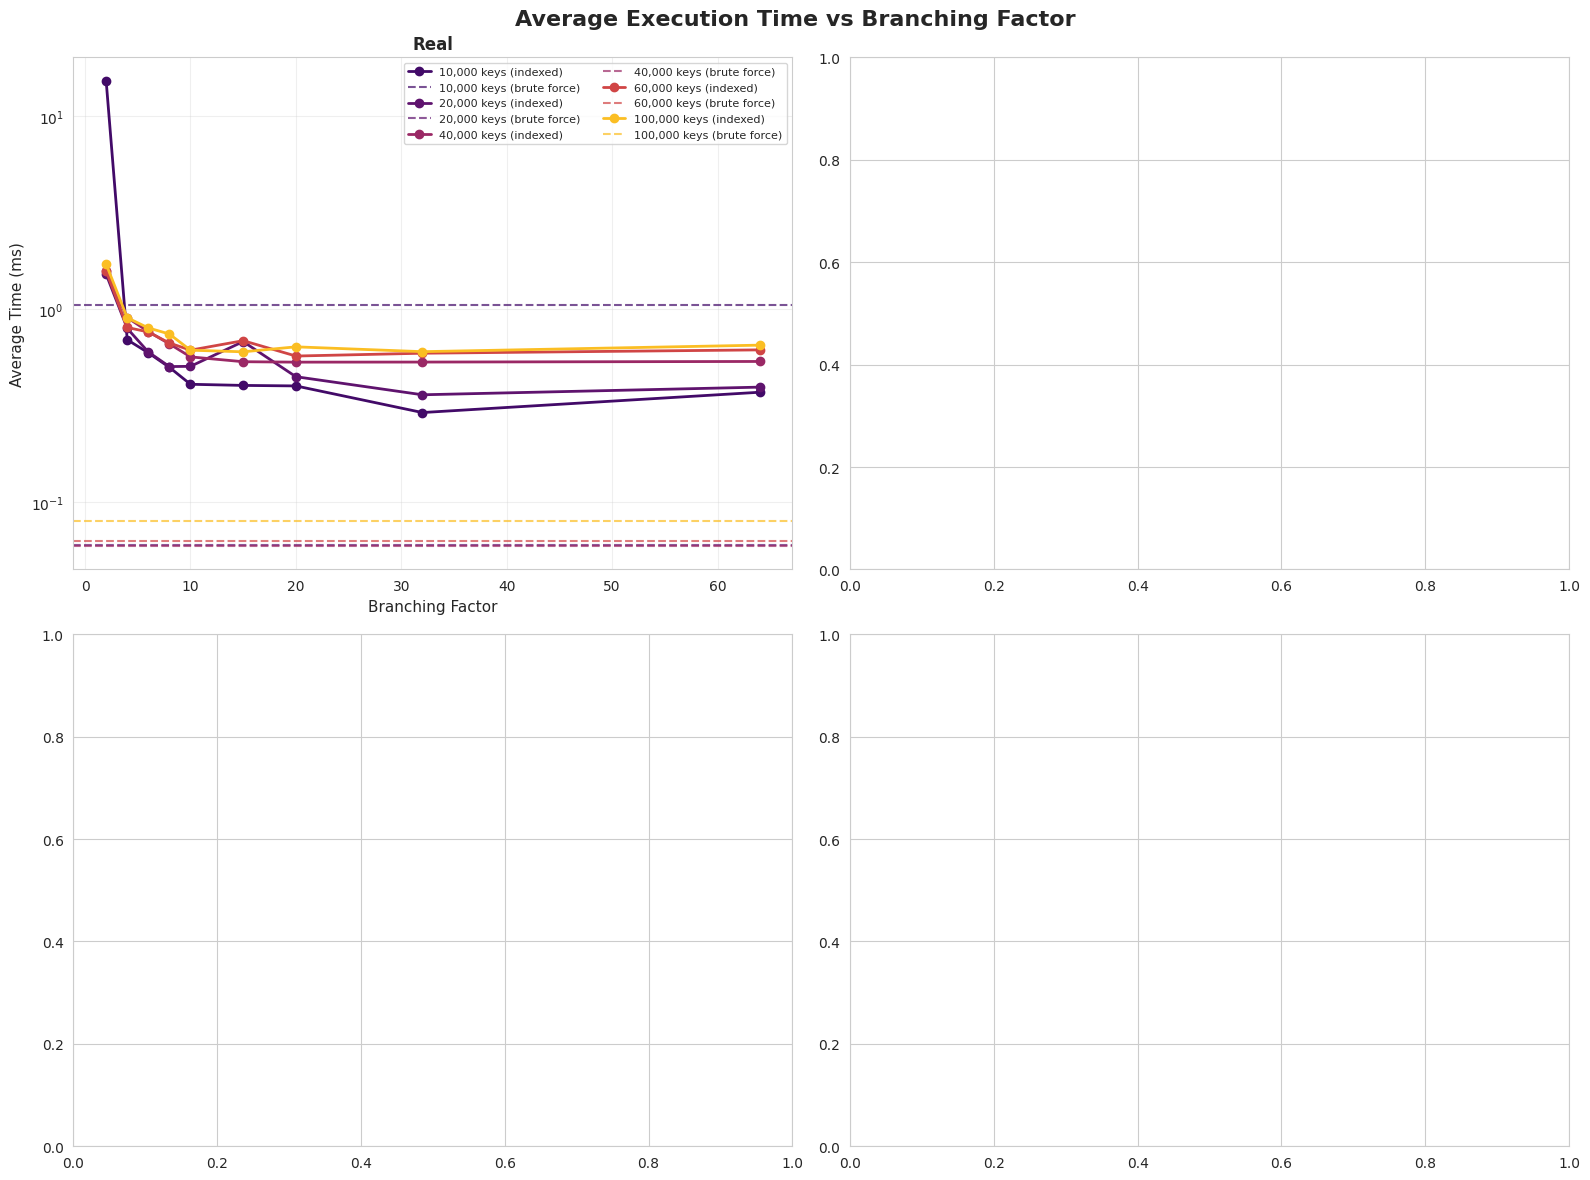

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Average Execution Time vs Branching Factor', fontsize=16, fontweight='bold')
from matplotlib.colors import LinearSegmentedColormap

# Define key counts and create a gray-to-black color map
key_counts = [10000, 20000, 40000, 60000, 100000]

base = plt.cm.inferno
cmap = LinearSegmentedColormap.from_list(
    "inferno_dark",
    base(np.linspace(0.2, 0.85, 256))
)

norm = plt.Normalize(vmin=min(key_counts), vmax=max(key_counts))

for idx, distribution in enumerate(CONFIG['distributions']):
    ax = axes[idx // 2, idx % 2]
    
    df_dist = df_results[df_results['distribution'] == distribution]
    
    # Plot brute force and indexed times for different number of keys
    for num_keys in key_counts:
        if num_keys in df_dist['num_keys'].values:
            df_nk = df_dist[df_dist['num_keys'] == num_keys]
            color = cmap(norm(num_keys))
            
            # Plot indexed time (solid line)
            ax.plot(df_nk['branching_factor'], df_nk['indexed_time_mean'] * 1000, 
                   marker='o', linestyle='-', color=color, linewidth=2,
                   label=f'{num_keys:,} keys (indexed)')
            
            # Plot brute force time as horizontal line (same for all branching factors)
            bf_time = df_nk['brute_force_time_mean'].iloc[0] * 1000
            ax.axhline(y=bf_time, color=color, linestyle='--', linewidth=1.5, alpha=0.7,
                      label=f'{num_keys:,} keys (brute force)')
    
    ax.set_xlabel('Branching Factor', fontsize=11)
    ax.set_ylabel('Average Time (ms)', fontsize=11)
    ax.set_title(f'{distribution.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()